# openCOSMO-RS 

This tutorial demonstrates how to perform an OpenCOSMO-RS calculation using the ORCA python interface (OPI) and combining it with the [openCOSMO-RS_py](https://github.com/TUHH-TVT/openCOSMO-RS_py) project to calculate sigma profiles and solubilities.

In this notebook we will:
1.  Import the required Python dependencies
2.  Define a working directory
3.  Prepare and visualize input structures
4.  Run ORCA calculations with COSMO solvation
5.  Parse .orcacosmo output files and extract sigma profiles
6.  Compute solubility using openCOSMO-RS (non-iterative and iterative methods)

> **Note:** For this notebook to work you will have to install opencosmors_py from GitHub into your OPI `venv` by activating the `.venv` and using:

```
uv pip install git+https://github.com/TUHH-TVT/openCOSMO-RS_py
```

For more details visit the [openCOSMO-RS_py](https://github.com/TUHH-TVT/openCOSMO-RS_py) project on GitHub.

## Step 1: Import Dependencies

We start by importing the modules needed for:
- Interfacing with ORCA input/output
- Plotting results
- Numerical calculations and data handling
- Handling for directory
- Performing COSMO-RS calculations using the openCOSMO-RS library
> **Note:** We additionally import modules for visualization/plotting like `py3Dmol`. For this, it might be necessary to install `py3Dmol` into your OPI `venv` (e.g., by activating the `.venv` and using `uv pip install py3Dmol`).

In [1]:
# > Import pathlib for directory handling
from pathlib import Path
import shutil

# > Import necessary libraries for numerical computations
import numpy as np
from scipy.optimize import fsolve

# > Import the openCOSMO-RS library components
from opencosmorspy.parameterization import openCOSMORS24a
from opencosmorspy.cosmors import COSMORS
from opencosmorspy.input_parsers import SigmaProfileParser

# > OPI imports for performing ORCA calculations and reading output
from opi.core import Calculator
from opi.output.core import Output
from opi.input.structures.structure import Structure
from opi.input.simple_keywords import SolvationModel, Solvent

# > Import libraries for visualization
from matplotlib import pyplot as plt
import py3Dmol

## Step 2: Define Working Directory

All actual calculations will be performed in a subfolder **RUN**.

In [2]:
# > Calculation is performed in `RUN`
working_dir = Path("RUN")
# > The `working_dir`is automatically (re-)created
shutil.rmtree(working_dir, ignore_errors=True)
working_dir.mkdir()

## Step 3: Prepare and Visualize Input Structures

We use **water** as our example molecule. The 3D structure in Cartesian coordinates is defined in XYZ format and visualized.

In [3]:
# > define cartesian coordinates in Angstroem as python string 
xyz_data = """\
3

  O  -0.0007948665470900  0.4014278382603300  0.0000000000000000
  H  -0.7647999815056600  -0.2022173883142000  0.0000000000000000
  H  0.7655948480527500  -0.1992104499461300  0.0000000000000000\n
"""
# > Visualize the input structure
view = py3Dmol.view(width=400, height=400)
view.addModel(xyz_data, 'xyz')
view.setStyle({}, {'stick': {'radius': 0.1}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.show()

# > Write the input structure to a file for reading
with open(working_dir / "struc.xyz","w") as f:
    f.write(xyz_data)

# > Load the molecular structure from XYZ file
structure = Structure.from_xyz(working_dir / "struc.xyz")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 4: Calculation with openCOSMO-RS Solvation

We run a caculation using the **openCOSMO-RS solvation model** with ethanol as the solvent. First, we set up the calculator:

In [4]:
def setup_calc(basename : str, working_dir: Path, structure: Structure, ncores: int = 4) -> Calculator:
    # > Set up a Calculator object
    calc = Calculator(basename=basename, working_dir=working_dir)
    # > Assign structure to calculator
    calc.structure = structure

    # > COSMO-RS simple keyword
    calc.input.add_arbitrary_string("!COSMORS(ethanol)")

    # Define number of CPUs for the calcualtion
    calc.input.ncores = ncores # > 4 CPUs for this ORCA run

    return calc

basename = "opencosmors"
calc = setup_calc(basename=basename,working_dir=working_dir,structure=structure)

Next, we run the calculation:

In [5]:
def run_calc(calc: Calculator) -> Output:
    # > Write the ORCA input file
    calc.write_input()
    # > Run the ORCA calculation
    print("Running ORCA calculation ...", end="")
    calc.run()
    print("   Done")

    # > Get the output object
    output = calc.get_output()
    
    return output

output = run_calc(calc)

Running ORCA calculation ...   Done


Finally, we check that the calculation did terminate normally and converged:

In [6]:
def check_termination(output: Output):
    # > Check for proper termination of ORCA
    status = output.terminated_normally()
    if not status:
        # > ORCA did not terminate normally
        raise RuntimeError(f"ORCA did not terminate normally, see output file: {output.get_outfile()}")
    
check_termination(output)

## Step 5: Analyze COSMO Output and Sigma Profiles

After the ORCA OpenCOSMO-RS calculation completes, we parse the resulting .orcacosmo files to:

- Visualize the sigma profile (σ-profile)

- Extract molecular descriptors such as dipole moment, surface area, volume, and hydrogen-bonding moments

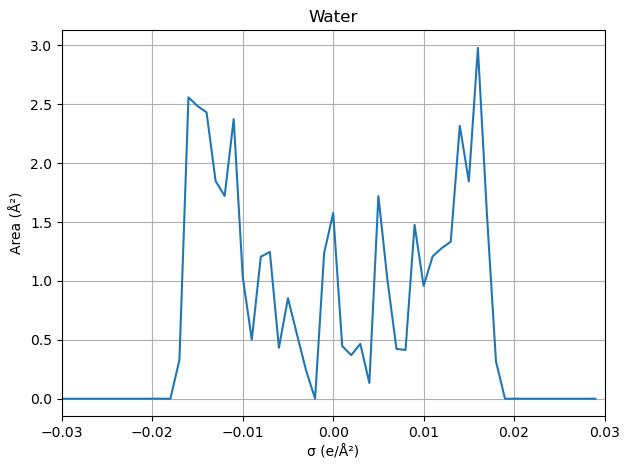

sigma_moments: [4.28977468e+01 7.90903554e-05 6.05283055e+01 3.89164821e+00
 1.20345287e+02 1.77937287e+01 2.66092559e+02]
hb_donor_moment: [5.11873012 2.60564439 0.85940158]
hb_acceptor_moment: [5.76486365 3.31610676 1.37737025]
energy_dielectric: -32.83919025918012
dipole_moment: None
area_total: 42.897746777517476
volume: 25.36550524969701


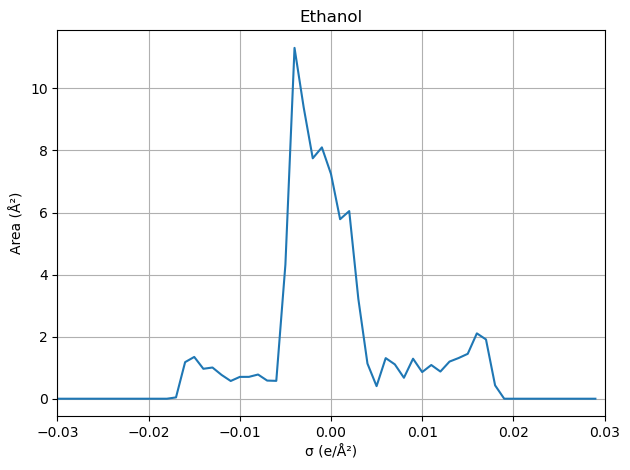

sigma_moments: [ 8.95401962e+01 -3.52247325e-04  4.47559164e+01  1.76051131e+01
  8.17805643e+01  4.88191312e+01  1.85692127e+02]
hb_donor_moment: [2.30899094 1.1905562  0.38328986]
hb_acceptor_moment: [4.83674399 2.87227988 1.31135965]
energy_dielectric: -25.107211968398246
dipole_moment: None
area_total: 89.54019619110814
volume: 68.36643463429641


In [7]:
def process_molecule(file_path: Path, name: str) -> None:
    """Process .orcacosmo file to visualize sigma profile and extract descriptors"""
    spp = SigmaProfileParser(file_path)
    
    # > Generate sigma profile
    sigmas, areas = spp.cluster_and_create_sigma_profile()
    
    plt.figure()
    plt.title(name)
    plt.plot(sigmas, areas)
    plt.xlim([-0.03, 0.03])
    plt.xlabel("σ (e/Å²)")
    plt.ylabel("Area (Å²)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # > Calculate descriptors
    spp.calculate_sigma_moments()
    descriptors = {
        'sigma_moments': spp['sigma_moments'],
        'hb_donor_moment': spp['sigma_hydrogen_bond_donor_moments'][2:5],
        'hb_acceptor_moment': spp['sigma_hydrogen_bond_acceptor_moments'][2:5],
        'energy_dielectric': spp['energy_dielectric'],
        'dipole_moment': spp['dipole_moment'],
        'area_total': spp['area'],
        'volume': spp['volume']
    }
    for key, value in descriptors.items():
        print(f"{key}: {value}")

# > Define paths to .orcacosmo files for the solute and solvent
cosmo_files = {
    'Water': working_dir / (basename + '.solute.orcacosmo'),
    'Ethanol': working_dir / (basename + '.solvent.orcacosmo')
}

# > Loop through and process both solute and solvent
for custom_name, file_path in cosmo_files.items():
    process_molecule(file_path, name=custom_name)

## Step 6: Predict Solubility of Paracetamol Using openCOSMO-RS

We use the openCOSMO-RS to calculate the activity coefficient (ln(γ)) and predict solubility using both:

- A non-iterative method

- An iterative method that solves the full equilibrium condition

The results are printed and compared.

### Structure of Paracetamol:

In [8]:
# > define cartesian coordinates in Angstroem as python string 
xyz_data = """\
20
energy: -32.783632377928 gnorm: 0.000608672974 xtb: 6.7.1 (edcfbbe)
C      2.88225    1.70760    0.08636
C      1.87583    0.57255    0.08465
H      3.88408    1.29416    0.14629
H      2.79182    2.28846   -0.82886
H      2.71377    2.36342    0.93735
O      2.19537   -0.59390    0.10126
N      0.59013    1.02699    0.05895
C     -0.60624    0.29815    0.04364
H      0.46337    2.02968    0.04757
C     -1.80437    1.01047    0.01777
C     -1.86108   -1.74887    0.03135
H     -1.78549    2.09153    0.01346
C     -3.01629    0.35366   -0.00279
C     -0.64533   -1.09159    0.05178
H      0.27418   -1.65102    0.07346
C     -3.05363   -1.03730    0.00247
H     -3.94534    0.90006   -0.02339
O     -4.26895   -1.65165   -0.02125
H     -1.88115   -2.83055    0.03727
H     -4.14859   -2.60876   -0.01690

"""
# > Visualize the input structure
view = py3Dmol.view(width=400, height=400)
view.addModel(xyz_data, 'xyz')
view.setStyle({}, {'stick': {'radius': 0.1}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.show()

# > Write the input structure to a file for reading
with open(working_dir / "paracetamol.xyz","w") as f:
    f.write(xyz_data)

basename_paracetamol = "opencosmors_paracetamol"
structure_paracetamol = Structure.from_xyz(working_dir / "paracetamol.xyz")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### openCOSMO-RS calculation for Paracetamol:

We can re-use the helper functions defined above to run the orca calculation and obtain the `.orcacosmo` file for paracetamol:

In [9]:
calc = setup_calc(basename=basename_paracetamol,working_dir=working_dir,structure=structure_paracetamol)
output = run_calc(calc)
check_termination(output)

Running ORCA calculation ...   Done


### Constants and solute specific experimental data

Solute specific constants are required and can be obtained for example from [NIST](https://webbook.nist.gov/cgi/cbook.cgi?ID=C103902&Mask=4#Thermo-Phase).

In [10]:
R = 8.314 # > Gas constant J/(mol·K)
TEMP = 298.15 # > Temperature for the solubility calculation (K)
# > Solute specific: 
DELTA_H_FUSION = 27.1e3 # > Fusion enthalpy of the solute (J/mol)
T_FUSION = 443.6 # > Fusion temperature of the solute (K), aka melting point of the solute

Now the solubilities of paracetamol in water and in ethanol are calculated. The resulting solubility is expressed in mole fractions

$x_\text{solvent}=(\frac{n_{\text{solute}}}{n_{\text{solute}} + n_{\text{solvent}}})$

In [11]:
def compute_ln_gamma(crs: COSMORS, mole_fractions: list[float], temp: float) -> float:
    """Compute ln(gamma) for a given composition at specified temperature using openCOSMO-RS"""
    crs.clear_jobs()
    crs.add_job(np.array(mole_fractions), temp, refst='pure_component')
    return crs.calculate()['tot']['lng'][0][0]

def solubility(crs: COSMORS, delta_h_fus: float, t_fus: float, temp: float, iterative: bool) -> float:
    """Estimate solubility from openCOSMO-RS ln(gamma)"""
    rhs = -delta_h_fus / R * (1 / temp - 1 / t_fus)

    if not iterative:
        ln_gamma_inf = compute_ln_gamma(crs, [0.0, 1.0], temp)
        return np.exp(rhs - ln_gamma_inf)
    
    def equation(x_guess: float) -> float:
        """Equilibrium condition to be solved"""
        x_guess = max(1e-15, x_guess)
        x_guess = min(1, x_guess)
        x = np.array([x_guess, 1 - x_guess])
        ln_gamma = compute_ln_gamma(crs, x, temp)
        return np.abs(ln_gamma + np.log(x_guess) - rhs)

    result = fsolve(equation, 1e-5)
    
    x_sol = max(1e-15, result[0])
    x_sol = min(1, x_sol)
    return x_sol

def run_solubility_analysis(crs: COSMORS, solute_path: str, solvent_paths: list[str], solute_label: str, solvent_labels: list[str]) -> None:
    """Run solubility analysis comparing non-iterative and iterative results for given solute/solvents."""
    if solvent_labels is None:
        solvent_labels = [Path(p).stem for p in solvent_paths]

    print("Solubility results in mole fractions:\n")
    print(f"Solute: {solute_label}\n")
    print(f"{'Solvent':<20} {'Non-Iterative':>15} {'Iterative':>15} {'Experimental':>15}")

    # > experimental reference data for comparison, taken from https://doi.org/10.1021/je990124v (for T = 298.15 K, converted from g/kg to mole fractions)
    exp_ref = {"Water" : 0.001772602, "Ethanol" : 0.075859954}

    for solvent_path, solvent_name in zip(solvent_paths, solvent_labels):
        crs.clear_molecules()
        crs.add_molecule([solute_path])
        crs.add_molecule([solvent_path])

        x_non_iter = solubility(crs, DELTA_H_FUSION, T_FUSION, TEMP, iterative=False)
        x_iter = solubility(crs, DELTA_H_FUSION, T_FUSION, TEMP, iterative=True)

        print(f"{solvent_name:<20} {x_non_iter:>15.5e} {x_iter:>15.5e} {exp_ref[solvent_name]:>15.5e}")


# > Set up openCOSMO-RS with the 2024a parameterization
crs = COSMORS(par=openCOSMORS24a())

# > Define file paths and labels
solute_file = working_dir / (basename_paracetamol + '.solute.orcacosmo')
solute_label = "Paracetamol"
solvent_files = [working_dir / (basename + '.solute.orcacosmo'), working_dir / (basename + '.solvent.orcacosmo')]
solvent_labels = ["Water", "Ethanol"]

# > Run solubility analysis
run_solubility_analysis(crs, solute_file, solvent_files, solute_label=solute_label, solvent_labels=solvent_labels)



Solubility results in mole fractions:

Solute: Paracetamol

Solvent                Non-Iterative       Iterative    Experimental
Water                    7.42369e-04     1.94890e-04     1.77260e-03
Ethanol                  1.71201e-01     9.11733e-02     7.58600e-02


For water the non-iterative solver gets closer to the experimental value, while for ethanol the iterative approach agrees better with the experiment.

## Summary

In this notebook we showed how OPI can be employed together with `openCOSMO-RS_py` to calculate the solubilitiy of paracetamol in water and in ethanol.